/tmp/ipykernel_997410/3017982746.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location="cpu"))


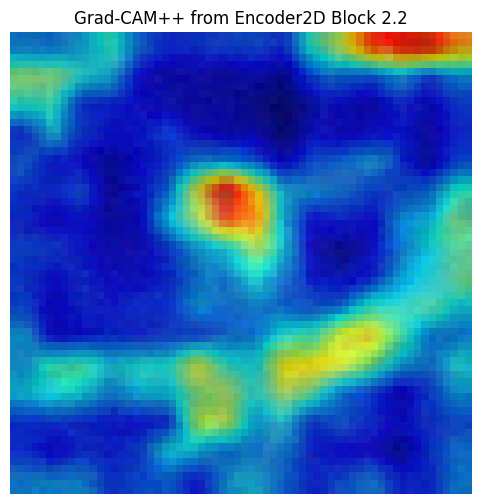

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
from CTencoder import CTModel  # 你自己的模型定义

# 保存特征与梯度
features = []
gradients = []

# 注册 Grad-CAM++ hook
def register_gradcampp_hook(model):
    target_layer = model.encoder.blocks[1][2]  # GCSA Block 2.2（你之前说的）
    
    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

# 预处理 .npz
def load_npz_image(npz_path):
    data = np.load(npz_path)
    image = data["data"]  # [H, W, 3]
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
    return image

# Grad-CAM++ 主函数
def compute_gradcampp(image_tensor, model, class_idx=None):
    image_tensor = image_tensor.unsqueeze(0).requires_grad_()  # [1, C, H, W]
    model.eval()

    output = model(image_tensor)  # 假设输出 shape 为 [1, num_classes]
    if class_idx is None:
        class_idx = output.argmax().item()

    model.zero_grad()
    target = output[0, class_idx]
    target.backward()

    feature = features[-1][0]  # [C, H, W]
    gradient = gradients[-1][0]  # [C, H, W]

    # Grad-CAM++ 权重计算
    grads_power_2 = gradient ** 2
    grads_power_3 = gradient ** 3
    sum_grad = torch.sum(feature * grads_power_2, dim=(1, 2), keepdim=True)  # [C,1,1]
    eps = 1e-8
    alpha = grads_power_2 / (2 * grads_power_2 + sum_grad * grads_power_3 + eps)  # [C,H,W]
    weights = torch.sum(alpha * torch.relu(gradient), dim=(1, 2))  # [C]

    cam = torch.sum(weights[:, None, None] * feature, dim=0)  # [H,W]
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam = cam.detach().cpu().numpy()
    return cam

# 可视化热图叠加
def visualize_cam_on_image(cam, image_tensor, title="Grad-CAM++"):
    img = image_tensor.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR → RGB

    overlay = 0.3 * img + 0.7 * heatmap
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 主函数
def main():
    npz_path = "/home/maweicheng/database/3_slice_64/cancer/LIDC-IDRI-0873_slice086.npz"
    model_path = "/home/maweicheng/multimodel/CT/cv_checkpoints/res_best_0.88.pth"
    
    image_tensor = load_npz_image(npz_path)
    model = CTModel()
    model.load_state_dict(torch.load(model_path, map_location="cpu"))

    register_gradcampp_hook(model)
    cam = compute_gradcampp(image_tensor, model)
    visualize_cam_on_image(cam, image_tensor, title="Grad-CAM++ from Encoder2D Block 2.2")

if __name__ == "__main__":
    main()


/tmp/ipykernel_997410/3114968924.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location="cpu")


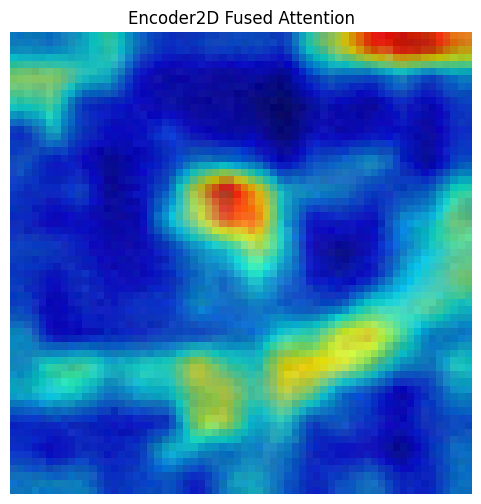

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
from CT.CTencoder import CTModel  # 你自己的模型定义

# 保存最后一个融合注意力的输出
fused_attention = []

# 注册 hook
def register_gcsa_hook(model):
    target_module = model.encoder.blocks[1][2]

    def hook_fn(module, input, output):
        fused_attention.append(output.detach().cpu())

    target_module.register_forward_hook(hook_fn)


# 加载 .npz 图像数据
def load_npz_image(npz_path):
    data = np.load(npz_path)
    image = data["data"]  # [H, W, 3]
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
    return image

# 前向推理
def run_inference(model, image_tensor):
    model.eval()
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0)
        _ = model(input_tensor)

# 可视化融合注意力叠加图
def plot_fused_attention(attn, image_tensor, title="Fused Attention Overlay"):
    if attn.ndim == 4:
        attn_map = attn[0].mean(dim=0)  # [C,H,W] → [H,W]
    else:
        print("❌ 注意力维度不支持:", attn.shape)
        return

    attn_map = attn_map.numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)

    # 原图转换
    img = image_tensor.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # resize 注意力图
    attn_resized = cv2.resize(attn_map, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * attn_resized), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR → RGB

    overlay = img * 0.3 + heatmap * 0.7
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 主函数
def main():
    npz_path = "/home/maweicheng/database/3_slice_64/cancer/LIDC-IDRI-0873_slice086.npz"
    model_path = "/home/maweicheng/multimodel/CT/cv_checkpoints/res_best_0.88.pth"
    image_tensor = load_npz_image(npz_path)
    model = CTModel()
    state_dict = torch.load(model_path, map_location="cpu")
    model.load_state_dict(state_dict)
    register_gcsa_hook(model)
    run_inference(model, image_tensor)
    if fused_attention:
        plot_fused_attention(fused_attention[-1], image_tensor, title="Encoder2D Fused Attention")

if __name__ == "__main__":
    main()
